In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import simplefilter
simplefilter(action="ignore")

# 1. Загрузка данных

Загрузим данные из файлов train.csv и test.csv. Разделим данные из первого набора на тренировочный и проверочный в соотношении 80/20, а второй будем использовать в качестве тестового.

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/teensdrafts/Python-Data-Analytics-Projects/refs/heads/main/Loan%20Approval%20Prediction/train.csv",
    index_col=0
)
test = pd.read_csv(
    "https://raw.githubusercontent.com/teensdrafts/Python-Data-Analytics-Projects/refs/heads/main/Loan%20Approval%20Prediction/test.csv",
    index_col=0
)

train, valid = np.split(df.sample(frac=1), [int(0.8 * len(df))])

# 2. Визуализация числовых значений

Построим гистограммы распределния числовых значений для классов loan_status = 0 и loan_status = 1

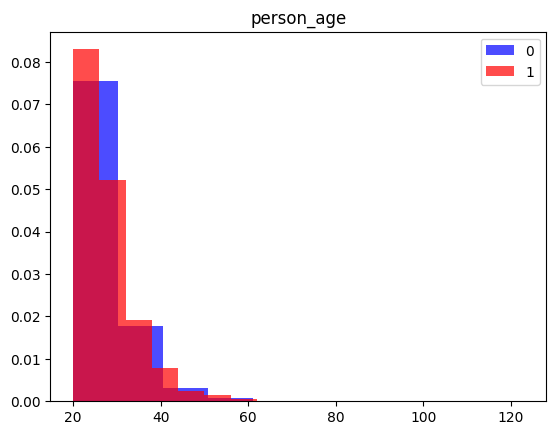

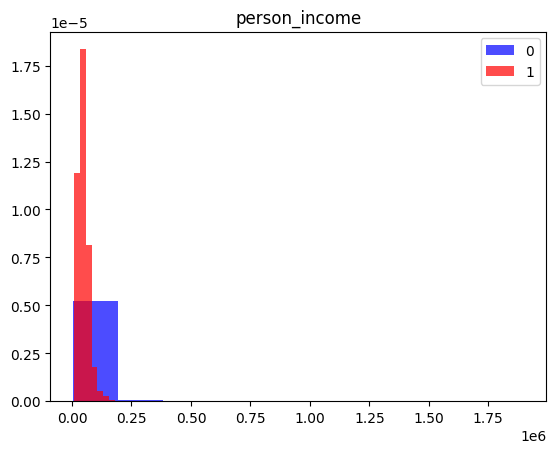

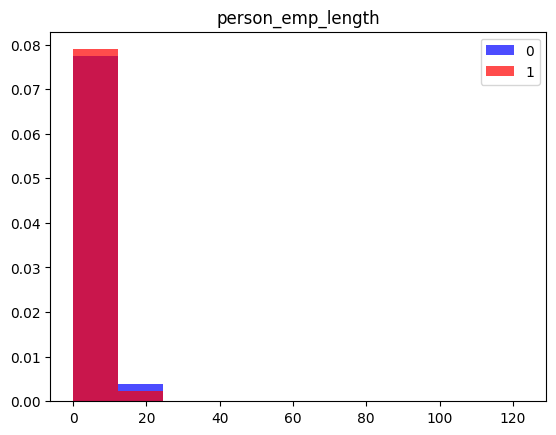

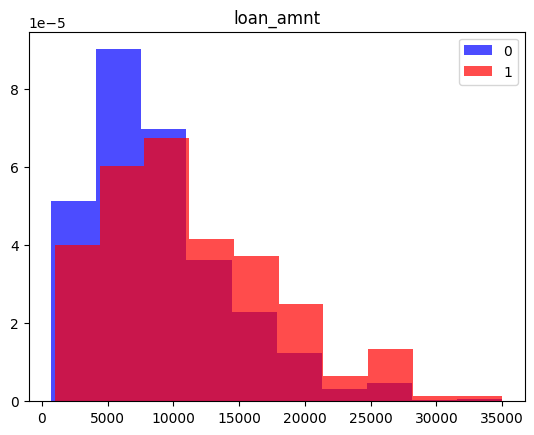

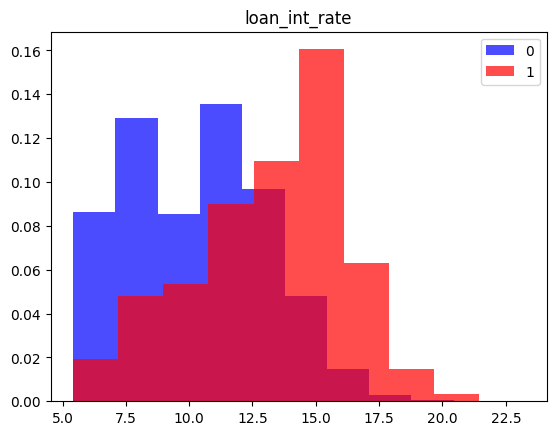

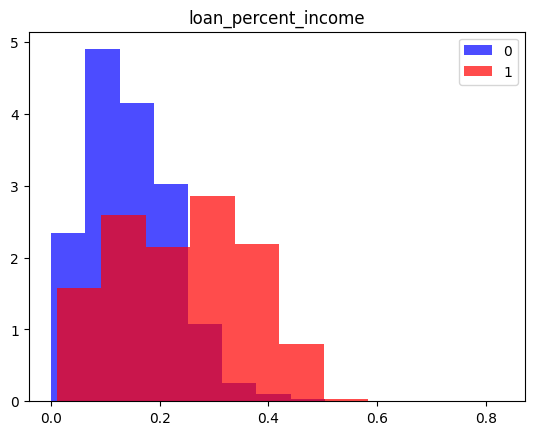

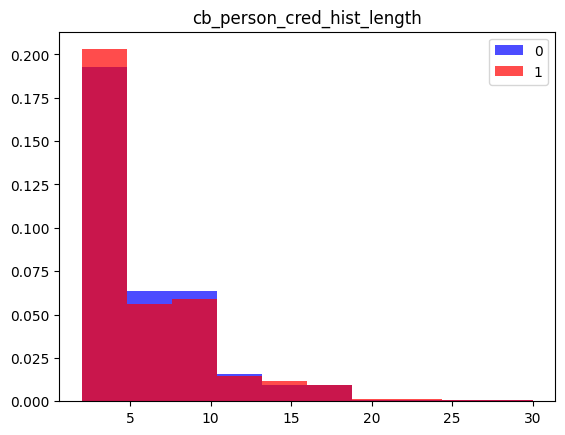

In [3]:
cols = train.select_dtypes(exclude=["object"]).columns[:-1]
for col in cols:
  plt.hist(train.query("loan_status == 0")[col], density=True, color="blue", alpha=0.7, label="0")
  plt.hist(train.query("loan_status == 1")[col], density=True, color="red", alpha=0.7, label="1")

  plt.title(col)

  plt.legend()
  plt.show()

# 3. Подготовка данных

In [4]:
from typing import Literal
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

## 3.1. Быстрое кодирование (one-hot-encoding)

In [5]:
def encode_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
  obj_cols = dataset.select_dtypes(include=["object"]).columns
  num_cols = dataset.select_dtypes(exclude=["object"]).columns

  return pd.concat(
      [
          pd.get_dummies(dataset[obj_cols], dtype=np.int8),
          dataset[num_cols]
      ],
      axis=1
  )

## 3.3. Data Oversampling

In [6]:
def oversample_dataset(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray]:
  ros = RandomOverSampler()
  X, y = ros.fit_resample(X, y)

  return X, y

## 3.4. Трансформация данных

In [7]:
# Обучающий набор
train_encoded = encode_dataset(train)
X_train = train_encoded.drop("loan_status", axis=1)
y_train = train_encoded["loan_status"]
X_train, y_train = oversample_dataset(X_train, y_train)

# Контрольный набор
valid_encoded = encode_dataset(valid)
X_valid = valid_encoded.drop("loan_status", axis=1)
y_valid = valid_encoded["loan_status"]

# Тестовый dataset
X_test = encode_dataset(test)

# 4. Обучение модели

In [8]:
from sklearn.metrics import classification_report
from sklearn.ensemble import HistGradientBoostingClassifier

В качестве модели будем использовать HistGradientBoostingClassifier из библиотеки sklearn.ensemble

In [9]:
gbc_model = HistGradientBoostingClassifier(learning_rate=0.01)
gbc_model.fit(X_train, y_train)
y_pred_train = gbc_model.predict(X_train)  # предсказания обучающих данных
y_pred_valid = gbc_model.predict(X_valid)  # предсказания контрольных данных

In [10]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88     40251
           1       0.94      0.79      0.86     40251

    accuracy                           0.87     80502
   macro avg       0.88      0.87      0.87     80502
weighted avg       0.88      0.87      0.87     80502

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     10044
           1       0.70      0.79      0.74      1685

    accuracy                           0.92     11729
   macro avg       0.83      0.87      0.85     11729
weighted avg       0.93      0.92      0.92     11729



In [11]:
y_pred_test = gbc_model.predict(X_test)

# 5. SHAP-значения

In [12]:
import shap

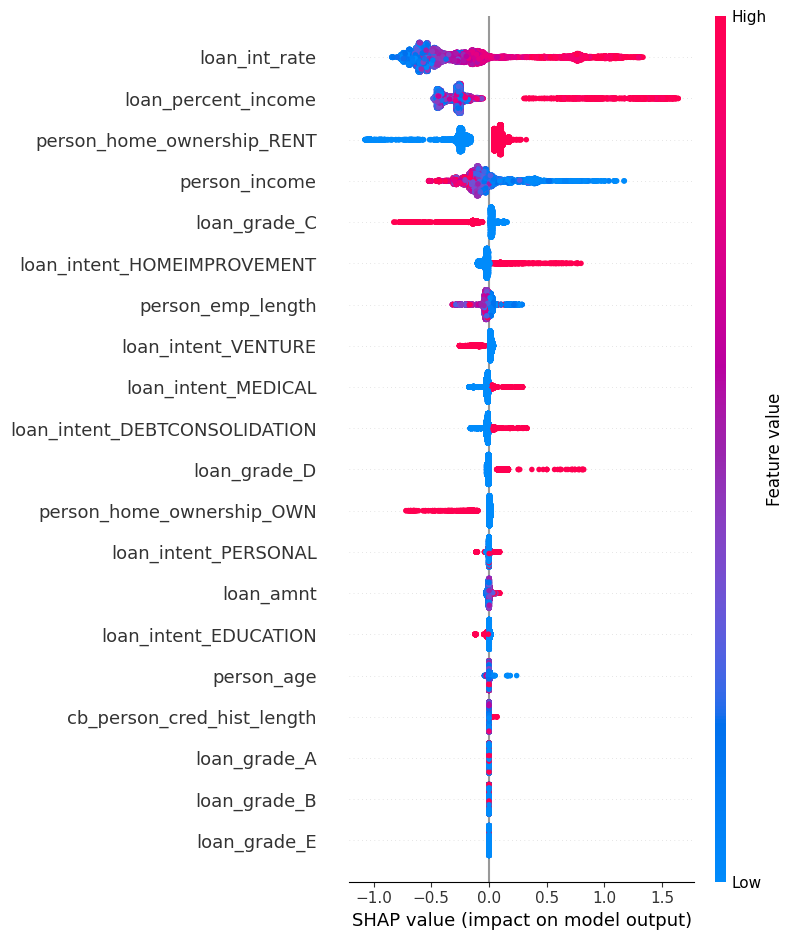

In [13]:
explainer = shap.Explainer(gbc_model)
shap_values = explainer(X_valid)

shap.summary_plot(shap_values, X_valid)

In [15]:
# pd.DataFrame(y_pred_test, columns=["loan_status"], index=test.index).to_csv("predictions.csv")